Best sigma: 1.0 metric: 0.2195309911247603
Std-Xav-Tanh: median MSE = 1.996e-01
Std-He-Tanh: median MSE = 1.610e-01


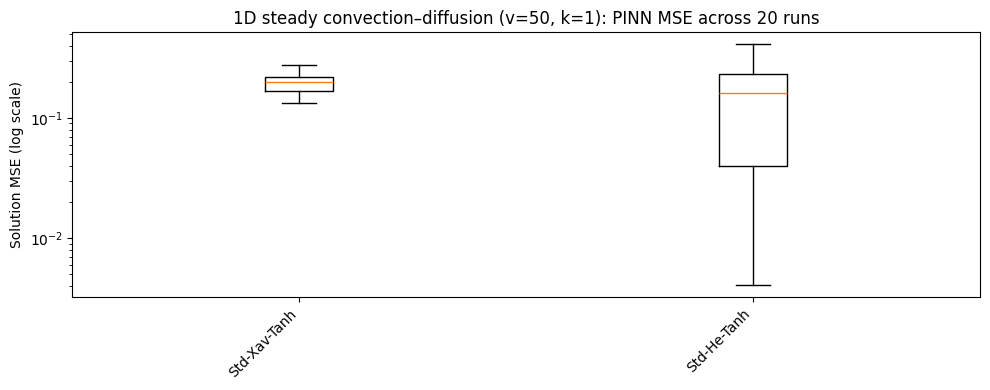

<Figure size 640x480 with 0 Axes>

: 

In [ ]:
# =========================
# Fig 5(a) for PINNs with TensorFlow/Keras)
# =========================
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
import matplotlib.pyplot as plt
import random, math

# Use float64 for stable higher-order derivatives
tf.keras.backend.set_floatx('float64')

# -------- Problem setup --------
v = 50.0   # advection (Case v= 1.0 works well)
k = 1.0    # diffusion

def u_true(x, v=v, k=k):
    # analytic solution of k u'' - v u' = 0 with u(0)=0, u(1)=1
    return (np.exp((v/k)*x) - 1.0) / (math.e**(v/k) - 1.0)

# Dense grid for MSE
x_eval = np.linspace(0.0, 1.0, 2001).reshape(-1,1)
u_eval = u_true(x_eval)

# Collocation + BC points
N_c = 2000
N_b = 200  # half at x=0, half at x=1
# N_c = 100
# N_b = 10  # half at x=0, half at x=1

rng = np.random.default_rng(123)
x_c_np = rng.random((N_c,1))           # uniform in (0,1)
x_b0_np = np.zeros((N_b//2,1))
x_b1_np = np.ones((N_b//2,1))
x_c  = tf.convert_to_tensor(x_c_np)
x_b0 = tf.convert_to_tensor(x_b0_np)
x_b1 = tf.convert_to_tensor(x_b1_np)

# -------- Model builder --------
class Sin(layers.Layer):
    def call(self, z): return tf.sin(z)

class SinusoidalMapping(tf.keras.layers.Layer):
    """
    z = sin(2π (x W^T + b)), with trainable W, b.
    n_features: number of sinusoidal features (width of this first mapping)
    sigma: stddev for W ~ N(0, sigma^2)  (bandwidth parameter in the article)
    """
    def __init__(self, n_features=32, sigma=1.0, **kwargs):
        super().__init__(**kwargs)
        self.n_features = n_features
        self.sigma = sigma

    def build(self, input_shape):
        in_dim = int(input_shape[-1])
        self.W = self.add_weight(
            name="W1",
            shape=(self.n_features, in_dim),
            initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=self.sigma),
            trainable=True,
            dtype=self.dtype,
        )
        self.b = self.add_weight(
            name="b1",
            shape=(self.n_features,),
            initializer="zeros",
            trainable=True,
            dtype=self.dtype,
        )

    def call(self, x):
        phase = tf.linalg.matmul(x, tf.transpose(self.W)) + self.b   # (batch, n_features)
        return tf.sin(2.0 * np.pi * phase)
    
def build_pinn(activation='tanh', init='glorot_uniform'):
    if activation == 'tanh':
        act = layers.Activation('tanh')
    elif activation == 'sigmoid':
        act = layers.Activation('sigmoid')
    elif activation == 'sin':
        act = Sin()
    else:
        raise ValueError("activation must be 'tanh', 'sigmoid', or 'sin'")

    if init == 'glorot_uniform':
        kinit = initializers.GlorotUniform()
    elif init == 'he_uniform':
        kinit = initializers.HeUniform()
    else:
        raise ValueError("init must be 'glorot_uniform' or 'he_uniform'")
#    sigma = 1.0          # try: 0.1, 0.32, 1.0, 3.2, 10.0 (mini log-grid)
    n_features = 32      # we can use 32–128; more features for tougher problems
    NN = keras.Sequential([
        # layers.Input((1,), dtype=tf.float64),
        # layers.Dense(32, activation=None, kernel_initializer=kinit, bias_initializer='zeros', dtype=tf.float64),
        # act,
        # Defining the first layer of sf-PINN
        keras.layers.Input((1,)),                                 # in_dim = 1

        SinusoidalMapping(n_features=n_features, sigma=best_sigma),    # <-- sf mapping
        keras.layers.Activation('tanh'),
        layers.Dense(10, activation=None, kernel_initializer=kinit, bias_initializer='zeros', dtype=tf.float64),
        act,
        layers.Dense(10, activation=None, kernel_initializer=kinit, bias_initializer='zeros', dtype=tf.float64),
        act,
        layers.Dense(10, activation=None, kernel_initializer=kinit, bias_initializer='zeros', dtype=tf.float64),
        act,
        layers.Dense(1,  activation=None, kernel_initializer=kinit, bias_initializer='zeros', dtype=tf.float64),
    ])
    return NN

# -------- PINN losses (PDE + BC) --------
@tf.function
def pde_residual(model, x):
    x = tf.cast(x, tf.float64)
    with tf.GradientTape(persistent=True) as t2:
        t2.watch(x)
        with tf.GradientTape() as t1:
            t1.watch(x)
            u = model(x)                # (N,1)
        u_x = t1.gradient(u, x)         # (N,1)
    u_xx = t2.gradient(u_x, x)          # (N,1)
    del t2
    return v * u_x - k * u_xx           # residual: v u' - k u''

def quick_sigma_sweep(sigmas, build_net_fn, train_once_fn):
    best_sigma, best_metric = None, float('inf')
    for s in sigmas:
        model = build_net_fn(s)
        metric = train_once_fn(model)   # e.g., validation loss or final MSE
        if metric < best_metric:
            best_metric, best_sigma = metric, s
    return best_sigma, best_metric

# Example usage :
def build_net_with_sigma(s):
    return keras.Sequential([
        keras.layers.Input((1,)),
        SinusoidalMapping(n_features=32, sigma=s),
        keras.layers.Activation('tanh'),
        keras.layers.Dense(32, activation='tanh',
                           kernel_initializer='glorot_uniform',
                           bias_initializer='zeros'),
        keras.layers.Dense(1, kernel_initializer='glorot_uniform',
                           bias_initializer='zeros'),
    ])


def pinn_loss(model, x_c, x_b0, x_b1, lam=1.0):
    r = pde_residual(model, x_c)
    L_pde = tf.reduce_mean(tf.square(r))
    u_b0 = model(x_b0)
    u_b1 = model(x_b1)
    L_bc = tf.reduce_mean(tf.square(u_b0)) + tf.reduce_mean(tf.square(u_b1 - 1.0))
    return (L_pde / lam) + L_bc, L_pde, L_bc

# -------- One training run --------
def train_one(model, steps=20000, lr=5e-3, lam=1.0, patience=500, min_lr=1e-6, verbose=False):
# def train_one(model, steps=200, lr=5e-3, lam=500.0, patience=500, min_lr=1e-6, verbose=False):

    opt = keras.optimizers.Adam(learning_rate=lr)
    best = np.inf
    plateau = 0
    for it in range(steps):
        with tf.GradientTape() as tape:
            loss, Lp, Lb = pinn_loss(model, x_c, x_b0, x_b1, lam=lam)
        grads = tape.gradient(loss, model.trainable_variables)
        opt.apply_gradients(zip(grads, model.trainable_variables))

        # reduce-on-plateau every 200 iters
        if (it+1) % 200 == 0:
            cur = float(loss.numpy())
            if verbose: print(f"it {it+1:5d}  loss={cur:.3e}  Lp={float(Lp.numpy()):.3e}  Lb={float(Lb.numpy()):.3e}  lr={opt.learning_rate.numpy():.2e}")
            if cur < best - 1e-9:
                best = cur; plateau = 0
            else:
                plateau += 1
                if plateau >= patience//200 and opt.learning_rate.numpy() > min_lr + 1e-12:
                    opt.learning_rate.assign(max(opt.learning_rate.numpy()*0.5, min_lr))
                    plateau = 0

    # MSE on dense grid
    u_hat = model(tf.convert_to_tensor(x_eval))
    mse = float(tf.reduce_mean(tf.square(u_hat - u_eval)).numpy())
    return mse

sigmas = [0.1, 0.32, 1.0, 3.2, 10.0]
best_sigma, best_metric = quick_sigma_sweep(sigmas, build_net_with_sigma, train_one)
print("Best sigma:", best_sigma, "metric:", best_metric)

# -------- Run multiple seeds per config --------
def set_seed(s):
    random.seed(s); np.random.seed(s); tf.random.set_seed(s)

def run_config(label, activation, init, n_runs=20, steps=20000, lr=5e-3, lam=1.0):
    mses = []
    for i in range(n_runs):
        set_seed(1000 + i)
        model = build_pinn(activation=activation, init=init)
        mse = train_one(model, steps=steps, lr=lr, lam=lam)
        mses.append(mse)
    print(f"{label}: median MSE = {np.median(mses):.3e}")
    return mses

# -------- Define configurations (as in Fig. 5(a) for PINNs) --------
configs = [
    ("Std-Xav-Tanh",    'tanh',    'glorot_uniform'),
    ("Std-He-Tanh",     'tanh',    'he_uniform'),
    ("Std-Xav-Sigmoid", 'sigmoid', 'glorot_uniform'),
    ("Std-He-Sigmoid",  'sigmoid', 'he_uniform'),
    ("Std-Xav-Sin",     'sin',     'glorot_uniform'),
    ("Std-He-Sin",      'sin',     'he_uniform'),
]

labels, data = [], []
for name, act, init in configs:
    mses = run_config(name, act, init, n_runs=20, steps=20000, lr=5e-3, lam=1.0)
    labels.append(name); data.append(mses)

# -------- Boxplot (log scale) --------
plt.figure(figsize=(10,4))
plt.boxplot(data, showfliers=False)
plt.yscale('log')
plt.xticks(range(1, len(labels)+1), labels, rotation=45, ha='right')
plt.ylabel('Solution MSE (log scale)')
plt.title(f'1D steady convection–diffusion (v={v:g}, k={k:g}): PINN MSE across 20 runs')
plt.tight_layout()
plt.show()
plt.savefig("fig5a_sfpinns.png", dpi=300, bbox_inches='tight')
#plt.close()

import pickle

# Save
with open("sfpinnresults.pkl", "wb") as f:
    pickle.dump({"labels": labels, "data": data}, f)



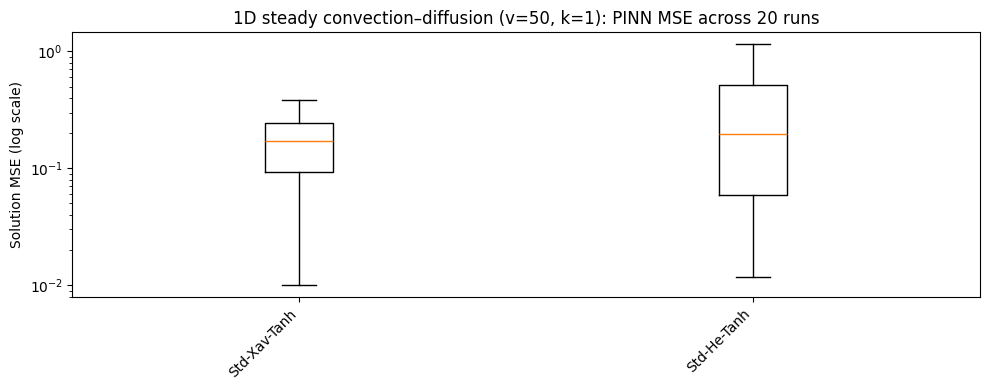

[[0.24106260263184778, 0.13479673916362686, 0.033035830651658195, 0.09483009278697863, 0.2393412130271692, 0.03377037397516325, 0.20092787340629173, 0.1909227925357758, 0.13213318135800975, 0.009999356852576293, 0.08738020491935225, 0.38126972395970615, 0.31098088397562645, 0.468775246979923, 0.23917333875509608, 0.07154666311803076, 0.14277748456035655, 0.14915444464938607, 0.24790346128453009, 0.37397977410816724], [0.2473357533533818, 0.013241596686500217, 0.2828308404331653, 0.011778049181533865, 0.23783664460117696, 0.15324413983369764, 0.1439761139572497, 0.06124878345217555, 0.09471914134353053, 0.5770012806746908, 0.05424553706084277, 0.7068837926280709, 1.4842733050549635, 2.2425870864813833, 0.24857466522233315, 0.06543489584836029, 0.014731942937252282, 0.015991395755548133, 0.49880689710149595, 1.1476375055276717]]
<class 'list'>


In [5]:
# Load
with open("sfpinnresults.pkl", "rb") as f:
    results = pickle.load(f)

labels = results["labels"]    # still list
data1   = results["data"] 

plt.figure(figsize=(10,4))
plt.boxplot(data1, showfliers=False)
plt.yscale('log')
plt.xticks(range(1, len(labels)+1), labels, rotation=45, ha='right')
plt.ylabel('Solution MSE (log scale)')
plt.title(f'1D steady convection–diffusion (v={v:g}, k={k:g}): PINN MSE across 20 runs')
plt.tight_layout()
plt.show()
print(data1)
print(type(data1))